In [264]:
%matplotlib inline
import pandas as pd

In [265]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [266]:
from pyxirr import xirr

In [267]:
dfw = pd.read_csv("data_in_csv.csv", index_col=0,parse_dates=True)
#dfw = df[df.index.day_of_week == 0]
#dfw.head()
dfw = dfw[:"2019"]

In [268]:
dfw

,Close
Date,
2000-01-07,1613.30
2000-01-14,1622.75
2000-01-21,1620.60
2000-01-28,1599.10
2000-02-04,1599.75
...,...
2019-11-29,12056.05
2019-12-06,11921.50
2019-12-13,12086.70


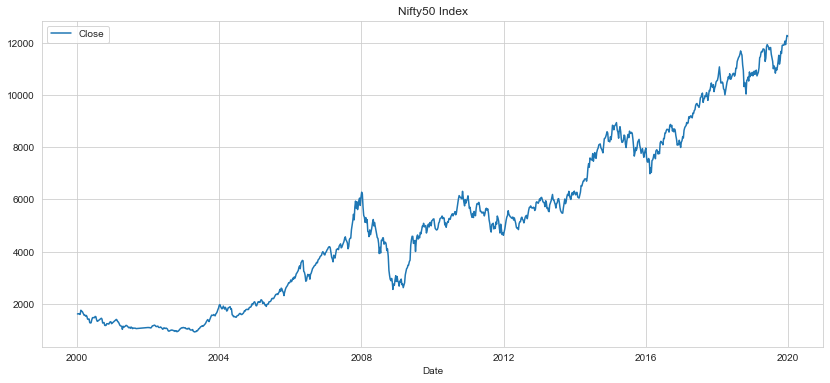

In [269]:
plt.figure(figsize=(14,6))
plt.title("Nifty50 Index")

sns.lineplot(data=dfw)
sns.set_style("whitegrid")

In [270]:
dfw = dfw.rename(columns = {"Close": "close"})

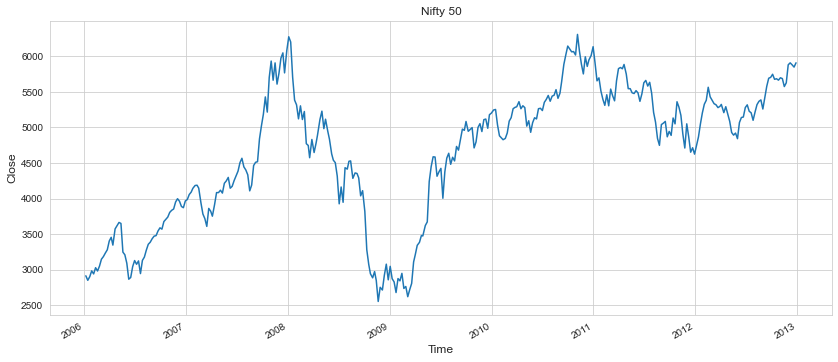

In [271]:
ax = dfw['2006':'2012'].plot(title='Nifty 50', legend=False, figsize=(14,6))
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Close', fontsize=12)
plt.show()

In [272]:
dfw["pct_change"] = dfw.close.diff()/dfw.close.shift(1)

<AxesSubplot:>

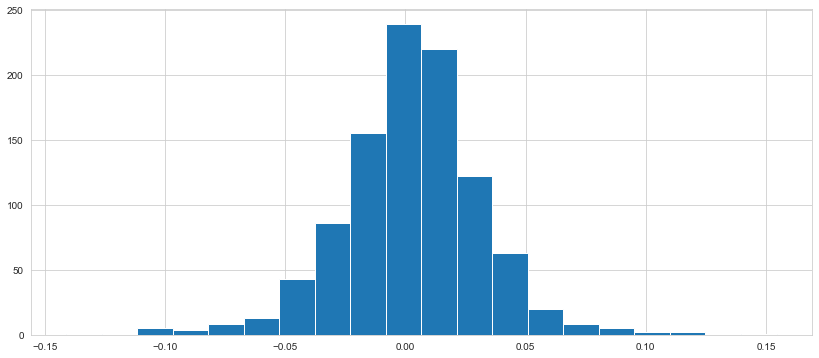

In [273]:
plt.figure(figsize=(14,6))
dfw["pct_change"].hist(bins=20)

In [274]:
expected_RR = 0.12
starting_sum = 100000
add_on_loss = 0.20
withdraw_on_profit = 0.20

In [275]:
dfw.loc[:, "weekly_RR"] = 1 + expected_RR/52
dfw.loc[dfw.index[0], "weekly_RR"] = starting_sum
dfw.loc[:, "expected_mean"] = dfw.weekly_RR.cumprod().round(2)

In [276]:
dfw = dfw.reset_index()

In [277]:
dfw

,Date,close,pct_change,weekly_RR,expected_mean
0,2000-01-07,1613.30,NaN,100000.000000,100000.00
1,2000-01-14,1622.75,0.005858,1.002308,100230.77
2,2000-01-21,1620.60,-0.001325,1.002308,100462.07
3,2000-01-28,1599.10,-0.013267,1.002308,100693.91
4,2000-02-04,1599.75,0.000406,1.002308,100926.28
...,...,...,...,...,...
994,2019-11-29,12056.05,0.011889,1.002308,988682.91
995,2019-12-06,11921.50,-0.011160,1.002308,990964.48
996,2019-12-13,12086.70,0.013857,1.002308,993251.32
997,2019-12-20,12271.80,0.015314,1.002308,995543.44


In [278]:
first = dfw.loc[0]
dfw.loc[0, "units"] = first.expected_mean/first.close
dfw.loc[0, "current_value"] = starting_sum

In [279]:
for i in range(1, len(dfw)):
    buy_event = False
    sell_event = False
    # if(prev_current_value <(1-add_on_loss)*prev_exp_mean): F4/N4,
        #else if(prev_current_value>(1+ withdraw_on_profit)*prev_exp_mean,F4/N4,
        # else prev_units))
    
    prev_row = dfw.loc[i-1]
    curr_row = dfw.loc[i]
    close_val = curr_row["close"]
    curr_exp_mean = curr_row["expected_mean"]
    
    prev_exp_mean = prev_row["expected_mean"]
    prev_units = prev_row["units"]
    prev_curr_val = prev_row["current_value"]
    
    curr_mkt_val = close_val * prev_units
    
    if curr_mkt_val < (1 - add_on_loss) * curr_exp_mean:
        buy_event = True
    elif curr_mkt_val > (1 + withdraw_on_profit) * curr_exp_mean:
        sell_event = True
    
    dfw.loc[i, "buy_event"] = buy_event
    dfw.loc[i, "sell_event"] = sell_event
    #residual: if(K3<(1-$Q$4)*F3,-(F3-K3),if(K3>(1+$Q$5)*F3,-(F3-K3),0))
    #units   : if(K3<(1-$Q$4)*F3,F4/N4,if(K3>(1+$Q$5)*F3,F4/N4,J3))
    
    if buy_event or sell_event:
        dfw.loc[i, "residual"] = curr_mkt_val - curr_exp_mean
    else:
        dfw.loc[i, "residual"] = 0    
    
    if buy_event or sell_event:
        dfw.loc[i, "units"] = curr_exp_mean / close_val
    else:
        dfw.loc[i, "units"] = dfw.loc[i-1, "units"]

    curr_row = dfw.loc[i]      
    dfw.loc[i, "current_value"] = curr_row.close * curr_row.units
    curr_row = dfw.loc[i]


In [280]:
dfw[dfw.buy_event == True]

,Date,close,pct_change,weekly_RR,expected_mean,units,current_value,buy_event,sell_event,residual
18,2000-05-12,1282.80,-0.098144,1.002308,104236.34,81.256891,104236.34,True,False,-24722.300454
57,2001-04-12,1024.90,-0.100649,1.002308,114040.89,111.270261,114040.89,True,False,-30760.702234
120,2002-10-25,932.18,-0.040631,1.002308,131864.41,141.458098,131864.41,True,False,-28140.498555
197,2004-05-14,1582.39,-0.123058,1.002308,157474.23,99.516699,157474.23,True,False,-34631.376535
301,2006-06-09,2866.30,-0.072800,1.002308,200133.64,69.822991,200133.64,True,False,-41791.592662
391,2008-03-07,4771.60,-0.086513,1.002308,246272.43,51.612128,246272.43,True,False,-56238.891413
408,2008-07-03,3925.75,-0.090388,1.002308,256114.32,65.239590,256114.32,True,False,-53498.008475
423,2008-10-17,3074.35,-0.062684,1.002308,265124.47,86.237569,265124.47,True,False,-64555.136830
567,2011-08-05,5211.25,-0.049389,1.002308,369490.22,70.902417,369490.22,True,False,-81071.678140
796,2016-02-12,6980.95,-0.067852,1.002308,626392.39,89.728818,626392.39,True,False,-131426.162836


In [281]:
dfw["cum_residual"] = dfw.residual.cumsum()
dfw["total_value"] = dfw.current_value + dfw.cum_residual

In [282]:
dfw = dfw.set_index("Date")

<AxesSubplot:xlabel='Date'>

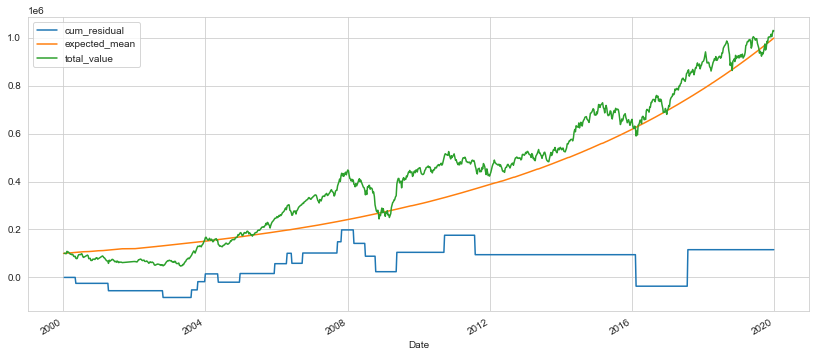

In [283]:
dfw.loc[:, ["cum_residual", "expected_mean", "total_value"]].plot(figsize=(14,6))

In [284]:
dfw.total_value

Date
2000-01-07             NaN
2000-01-14    1.005858e+05
2000-01-21    1.004525e+05
2000-01-28    9.911982e+04
2000-02-04    9.916011e+04
                  ...     
2019-11-29    1.014109e+06
2019-12-06    1.004082e+06
2019-12-13    1.016394e+06
2019-12-20    1.030188e+06
2019-12-27    1.028250e+06
Name: total_value, Length: 999, dtype: float64

In [285]:
x1 = dfw.loc[:, ["total_value"]].iloc[1] * -1 
x2 = dfw.loc[:, ["total_value"]].iloc[-1]
x11 = dfw.loc[:, ["close"]].iloc[1] * - 1
x22 = dfw.loc[:, ["close"]].iloc[-1]
x1_dates = dfw.index[1]
x2_dates = dfw.index[-1]
dates = [x1_dates, x2_dates]
values = [x1, x2]
values2 = [x11, x22]
xirr(dates, values)

0.12348731820272177

In [316]:

df1 = dfw.reset_index().iloc[[1, -1]].loc[:, ["Date", "total_value"]]
df1 = df1.rename(columns={"total_value": "cash_flow"})
df1.loc[1, "cash_flow"] = df1.loc[1, "cash_flow"] * -1
df1

,Date,cash_flow
1,2000-01-14,-1.005858e+05
998,2019-12-27,1.028250e+06


In [341]:
#df2 = dfw[dfw["residual"] < 0].reset_index().loc[:, ["Date", "residual"]]
df2 = dfw[(dfw["residual"] != 0) & (dfw["residual"].notna())].reset_index().loc[:, ["Date", "residual"]]
df2 = df2.rename(columns={"residual": "cash_flow"})

In [353]:
irr_df = pd.concat([df1, df2])
irr_df = irr_df.set_index("Date").sort_index().reset_index()
#irr_df
xirr(irr_df)

0.14147729424784503

In [354]:
df3 = dfw.reset_index().iloc[[1, -1]].loc[:, ["Date", "close"]]
df3 = df3.rename(columns={"close": "cash_flow"})
df3.loc[1, "cash_flow"] = df3.loc[1, "cash_flow"] * -1
xirr(df3)

0.10653478559618643